In [2]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt

/var/folders/1l/kxzgd7qj0958pcn5xj1149ph0000gn/T/ipykernel_47985/1514129803.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


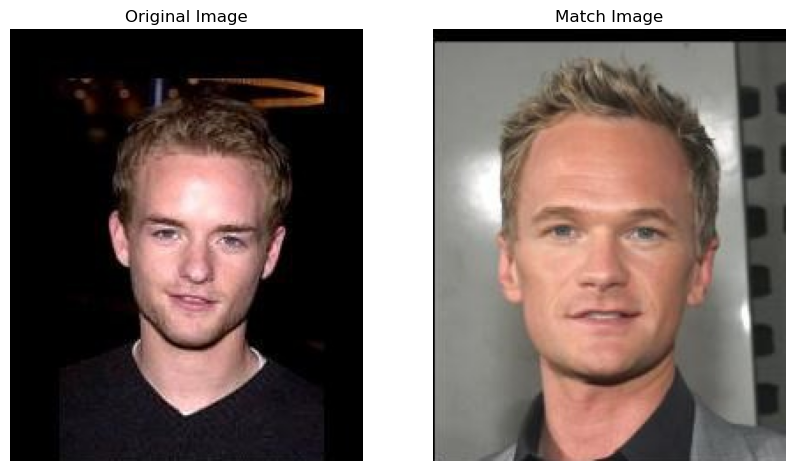

In [4]:
# Read in images from a filepath as graycsale.
rootpath_left='dataset/train/left'
rootpath_right='dataset/train/right'
gray = cv2.imread(os.path.join(rootpath_left, 'aaz.jpg'))
scene_gray = cv2.imread(os.path.join(rootpath_right, 'mqw.jpg'))

# Optional: Create a modified image by adding scale invariance and rotation invariance

#scene_gray = cv2.pyrDown(gray) #blurs an image and downsamples it
#rows, cols = scene_gray.shape[:2] #in case this is not a greyscale image
#rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1) #calculate an affine matrix of 2D rotation
#scene_gray = cv2.warpAffine(scene_gray, rotation_matrix, (cols, rows)) #apply an affine transformation to image

def imshow(image, *args, **kwargs):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')

# Display original image and scene image
plt.subplots(figsize=(10, 10)) 

plt.subplot(1,2,1)
plt.title('Original Image')
imshow(gray)  


plt.subplot(1,2,2)
plt.title('Match Image')
imshow(scene_gray)  

plt.show() 

/var/folders/1l/kxzgd7qj0958pcn5xj1149ph0000gn/T/ipykernel_47985/2874213701.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


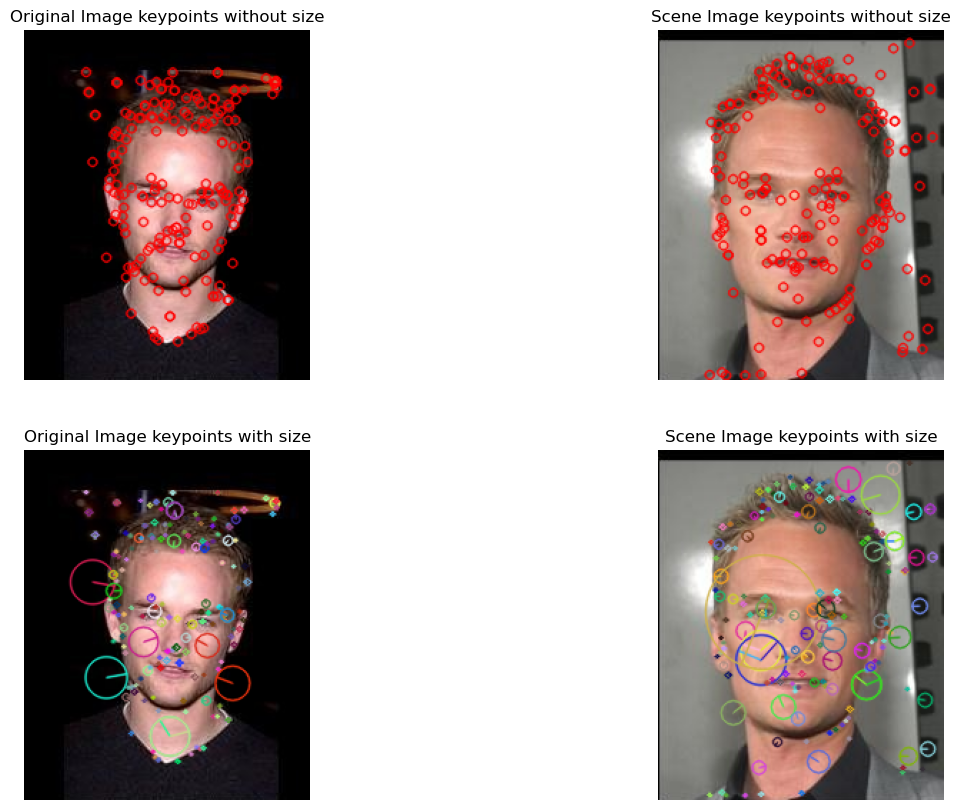

Number of keypoints detected in the original image:  182
Number of keypoints detected in the Scene image:  178


In [5]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray,None)
kp2, des2 = sift.detectAndCompute(scene_gray,None)

# Draws the small circles on the locations of keypoints without size
kp1_without_size = cv2.drawKeypoints(gray,kp1,None,color = (0, 0, 255)
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )
kp2_without_size = cv2.drawKeypoints(scene_gray,kp2,None,color = (0, 0, 255)
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(gray,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(scene_gray,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display images with&without the size of keypoints 
plt.subplots(figsize=(15, 10)) 

plt.subplot(2,2,1)
imshow(kp1_without_size)  
plt.title('Original Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,2)
imshow(kp2_without_size)  
plt.title('Scene Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,3)
imshow(kp1_with_size)  
plt.title('Original Image keypoints with size')
plt.axis('off')

plt.subplot(2,2,4)
imshow(kp2_with_size)  
plt.title('Scene Image keypoints with size')
plt.axis('off')

plt.show() 

# Print the number of keypoints detected
print("Number of keypoints detected in the original image: ", len(kp1))
print("Number of keypoints detected in the Scene image: ", len(kp2))

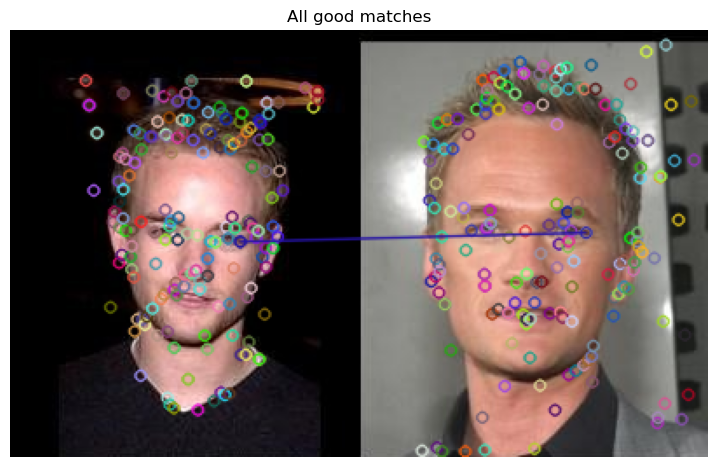


Number of good matches between two images:  1


In [6]:
# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Create a mask to draw all good matches
matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(gray,kp1,scene_gray,kp2,matches,None,**draw_params)


plt.figure(figsize=(9, 9))

imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# Print total number of good matches between two images
print("\nNumber of good matches between two images: ", len(good))

Not enough matches are found - 1/4


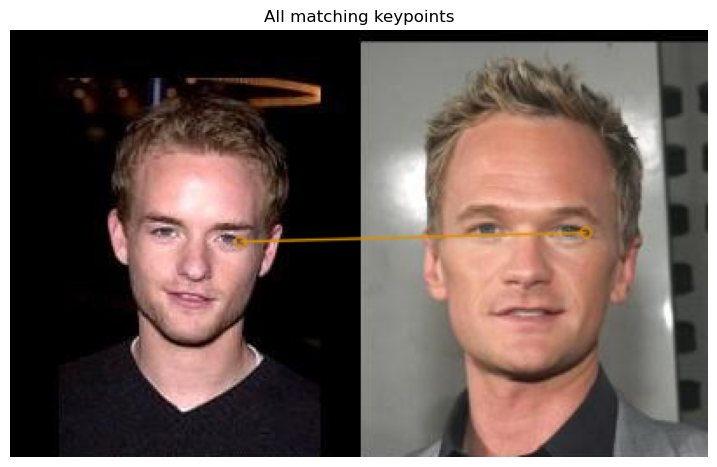

In [7]:
# Now we set a condition that at least N matches (defined by MIN_MATCH_NUM) are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)>= MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 5, 
                                   maxIters = 10) # try to change maxIters and see the effect
    # Where H is the resulting single-strain matrix.
    # status returns a list of feature points that represent successful matches.
    # ptsA, ptsB are keypoints.
    # The three parameters cv2.RANSAC, ransacReprojThreshold, maxIters are related to RANSAC.
    # ransacReprojThreshold: Maximum reprojection error in the RANSAC algorithm to consider a point as an inlier. 
    # maxIters: The maximum number of RANSAC-based robust method iterations.
    
    success = status.ravel().tolist()
    
    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(scene_gray, H, (gray.shape[1],gray.shape[0]),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", success.count(1)) # Returns the number of 1 in the success list

else:
    # Otherwise, print that “Not enough matches are found”.
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
    success = None


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                   #singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = success, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(gray,kp1,scene_gray,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(9, 9)) 

if success == None:
    imshow(success_matches)
    plt.title('All matching keypoints')
    plt.axis('off')
    
else:
    plt.subplot(2,1,1)
    imshow(success_matches)
    plt.title('All successful matches')
    plt.axis('off')
    
    plt.subplot(2,1,2)
    imshow(imgOut, 'gray')
    plt.title('Display detected template in scene image')
    plt.axis('off')

plt.show()

In [10]:
import pandas as pd
import os

csv_path = "dataset/train.csv"
left_train_path = "dataset/train/left/"
right_train_path = "dataset/train/right/"
df_match = pd.read_csv(csv_path)

right_img_lst = []
# list all figures in the right folder
for filename in os.listdir(right_train_path):
    if os.path.isfile(os.path.join(right_train_path, filename)):
        right_img_lst.append(filename)

# extract image path and concatenate with image file path
anchor_img_lst = [filename + ".jpg" for filename in df_match['left']]
positive_img_lst = [filename + ".jpg" for filename in df_match['right']]

# create a list of tuples of image pairs
match_pairs = list(zip(anchor_img_lst, positive_img_lst))

In [9]:
# create a list of tuples of random unmatched image pairs
unmatch_pairs = []
for i in range(len(anchor_img_lst)):
    rand_idx_lst = []
    while len(rand_idx_lst) < 19:
        rand_idx = np.random.randint(0, len(right_img_lst))
        if rand_idx not in rand_idx_lst and right_img_lst[rand_idx] != positive_img_lst[i]:
            rand_idx_lst.append(rand_idx)
    unmatch_pairs.append([(anchor_img_lst[i], right_img_lst[index]) for index in rand_idx_lst])

# create triplet with one left anchor image, one right positive image, and one random negative image
triplet_pairs = []
for i in range(len(anchor_img_lst)):
    while True:
        rand_idx = np.random.randint(0, len(right_img_lst))
        if right_img_lst[rand_idx] != match_pairs[i][1]:
            triplet = [match_pairs[i][0], match_pairs[i][1], right_img_lst[rand_idx]]
            triplet_pairs.append(triplet)
            break

negative_img_lst = [filename[2] for filename in triplet_pairs]

2000


In [13]:
# prepare image for the model
def prepare_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype("float32")
    img /= 255.0
    return img

# create a list of anchor, positive, and negative images
anchor_imgs = [prepare_image(os.path.join(left_train_path, filename)) for filename in anchor_img_lst]
positive_imgs = [prepare_image(os.path.join(right_train_path, filename)) for filename in positive_img_lst]
negative_imgs = [prepare_image(os.path.join(right_train_path, filename)) for filename in negative_img_lst]

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
base_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 245, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [17]:
# Define the left and right inputs
input_left = tf.keras.Input(shape=(200, 245, 3))
input_right = tf.keras.Input(shape=(200, 245, 3))

# Encode both left and right images using the same base network
encoded_left = base_model(input_left)
encoded_right = base_model(input_right)

# Calculate the Euclidean distance between the embeddings
# Can be changed to other distance functions
distance = tf.norm(encoded_left - encoded_right, axis=-1)

# Define the Siamese model
siamese_model = tf.keras.Model(inputs=[input_left, input_right], outputs=distance)

# Define the loss function
def triplet_loss(margin=1.0):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
        pos_distance = tf.norm(anchor - positive, axis=-1)
        neg_distance = tf.norm(anchor - negative, axis=-1)
        return tf.maximum(pos_distance - neg_distance + margin, 0.0)
    return loss


In [ ]:
# Compile the model with the triplet loss
siamese_model.compile(optimizer='adam', loss=triplet_loss())

# Prepare your triplets and train the model
siamese_model.fit([anchor_images, positive_images, negative_images], y_true, epochs=num_epochs, batch_size=batch_size)